In [1]:
######## Imports ##########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
import catboost as cb

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
%matplotlib inline

In [27]:
######## Import data and show correlations ##########
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [28]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [29]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [30]:
train['User_ID_encoded'] = train['User_ID'] - 1000000
test['User_ID_encoded'] = test['User_ID'] - 1000000

enc = LabelEncoder()
train['User_ID_encoded'] = enc.fit_transform(train['User_ID_encoded'])
test['User_ID_encoded'] = enc.transform(test['User_ID_encoded'])

In [31]:
# Product_ID preprocess e.g. P00069042 -> 69042
train['Product_ID_encoded'] = train['Product_ID'].str.replace('P00', '')
train['Product_ID_encoded'] = train['Product_ID_encoded'].apply(lambda x: x.lstrip('0'))
train['Product_ID_encoded'] = pd.to_numeric(train['Product_ID_encoded'],errors='coerce')

test['Product_ID_encoded'] = test['Product_ID'].str.replace('P00', '')
test['Product_ID_encoded'] = test['Product_ID_encoded'].apply(lambda x: x.lstrip('0'))
test['Product_ID_encoded'] = pd.to_numeric(test['Product_ID_encoded'],errors='coerce')

In [32]:
var_mod = ['City_Category', 'Stay_In_Current_City_Years', 'Gender', 'Age']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

In [33]:
####### Fill missing product categories with most frequent values ########
train['Product_Category_2'] = train.groupby('Product_Category_1')['Product_Category_2'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))
train['Product_Category_3'] = train.groupby(['Product_Category_2', 'Product_Category_1'])['Product_Category_3'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))

test['Product_Category_2'] = test.groupby('Product_Category_1')['Product_Category_2'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))
test['Product_Category_3'] = test.groupby(['Product_Category_2', 'Product_Category_1'])['Product_Category_3'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))

###### 0 seems to be the best options
#train.fillna(0.0, inplace=True)
#test.fillna(0.0, inplace=True)

In [34]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_encoded,Product_ID_encoded
0,1000001,P00069042,0,0,10,0,2,0,3,4.0,5.0,8370,0,69042
1,1000001,P00248942,0,0,10,0,2,0,1,6.0,14.0,15200,0,248942
2,1000001,P00087842,0,0,10,0,2,0,12,14.0,17.0,1422,0,87842
3,1000001,P00085442,0,0,10,0,2,0,12,14.0,17.0,1057,0,85442
4,1000002,P00285442,1,6,16,2,4,0,8,14.0,17.0,7969,1,285442


In [35]:
def validateModel(model):
    model.fit(x_train, y_train)
    train_pre = model.predict(x_train)
    test_pre = model.predict(x_test)
    
    print(model)
    print("RMSE: {0:.0f} \t Test RMSE: {1:.0f}".format(np.sqrt(mean_squared_error(y_train, train_pre)),np.sqrt(mean_squared_error(y_test,test_pre))))
    print()

In [46]:
validate = 'Purchase'
predictor_var = ['Product_Category_2', 'Product_Category_1', 'Product_Category_3', 'City_Category', 'Product_ID_encoded', 'Age', 'Stay_In_Current_City_Years', 'User_ID_encoded', "Occupation", 'Gender']

In [47]:
x_train, x_test, y_train, y_test = train_test_split(train[predictor_var], train[validate], test_size = 0.25, random_state=42)

In [48]:
####### Check different models ########
linreg = LinearRegression()
validateModel(linreg)

xgb_reg = XGBRegressor(random_state=42)
validateModel(xgb_reg)

gradB = GradientBoostingRegressor(random_state=42)
validateModel(gradB)

#nn = MLPRegressor(random_state=42, hidden_layer_sizes=[16, 16])
#validateModel(nn)

cat = cb.CatBoostRegressor(random_state=42, verbose=0)
validateModel(cat)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE: 4627 	 Test RMSE: 4624



/home/k/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)
RMSE: 2912 	 Test RMSE: 2929

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          r

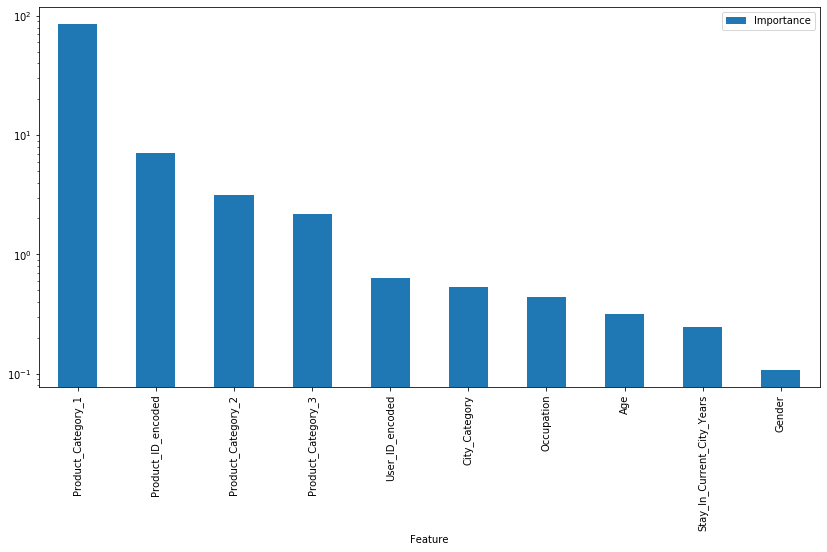

In [49]:
####### Print most important features ########
features = pd.DataFrame( {'Importance':cat.feature_importances_}, index=predictor_var)
features.index.name = 'Feature'
features.sort_values(by=['Importance'], ascending=False, inplace=True)
features.plot(kind='bar', logy=True, figsize=(14, 7))

In [67]:
####### Tuning best model with gender ########
predictor_var = ['Product_Category_2', 'Product_Category_1', 'Product_Category_3', 'City_Category', 'Product_ID_encoded', 'Age', 'Stay_In_Current_City_Years', 'User_ID_encoded', "Occupation", 'Gender']

# The best parameters
param_grid = {
        "iterations": [1000],
        "learning_rate": [0.04],
        'depth': [10]
    }

#best = cb.CatBoostRegressor(random_state=42, depth=10, learning_rate=0.04)
best = GradientBoostingRegressor(random_state=42, n_estimators=1150, min_samples_leaf=100, max_depth=10, verbose=1)
#validateModel(best)
#2497

      Iter       Train Loss   Remaining Time 
         1    21951762.7548           81.89m
         2    19276397.6096           81.02m
         3    17100194.7935           80.01m
         4    15332016.1691           79.70m
         5    13893899.5654           79.17m
         6    12722692.7462           78.89m
         7    11773194.4970           78.96m
         8    10988774.5336           79.05m
         9    10345842.6865           78.85m
        10     9814969.6012           79.02m
        20     7705414.3235           76.22m
        30     7238232.7938           71.79m
        40     7025914.3162           67.48m
        50     6887866.8270           63.05m
        60     6736869.1250           60.19m
        70     6640543.1703           56.21m
        80     6542309.1947           53.53m
        90     6483909.3538           50.60m
       100     6429499.3413           48.43m
       200     6028802.6960           35.85m
       300     5805326.2496           29.30m
       40

In [68]:
### Now fit on all data with best parameters
best_trained = best.fit(train[predictor_var], train[validate])

      Iter       Train Loss   Remaining Time 
         1    21936292.4951           93.57m
         2    19273409.4548           92.59m
         3    17108855.7988           91.92m
         4    15345593.7209           91.76m
         5    13916761.4320           91.71m
         6    12743265.5834           91.32m
         7    11784005.6108           91.34m
         8    11012266.0497           91.30m
         9    10382410.5391           91.03m
        10     9854085.5193           91.06m
        20     7697441.1806           88.81m
        30     7219230.2323           84.26m
        40     6993074.9339           79.21m
        50     6837255.0177           74.78m
        60     6732034.9710           70.04m
        70     6640176.0845           65.76m
        80     6558767.9677           62.46m
        90     6498915.0811           58.82m
       100     6422188.1296           56.55m
       200     6035749.8203           42.07m
       300     5818671.8780           34.16m
       40

In [69]:
######## Save output ##########
purchase_out = best_trained.predict(test[predictor_var])

out = pd.read_csv("Sample_Submission_kopia.txt")
out['User_ID'] = test['User_ID']
out['Product_ID'] = test['Product_ID']
out[validate] = purchase_out

out.to_csv('sample_submission.csv', index=False)